# Data Prep

This notebook downloads liconn data, does some data inspection, and reshapes data into the formats required by FFN and RoboEM

In [1]:
import numpy as np
import tensorflow as tf
from cloudvolume import CloudVolume
import matplotlib.pyplot as plt
import imageryclient as ic
import h5py

from webknossos import Dataset
from webknossos.dataset import COLOR_CATEGORY
import scipy.io

from PIL import Image

2024-07-24 14:01:17.508093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download Data from cloudvolume

In [29]:
# Data volume: Liconn ground truth that they used for ffn training
vol = CloudVolume('gs://liconn-public/ExPID82_1/image_230130b', parallel=True, progress=True, mip=1, fill_missing=True)

RefreshError: Reauthentication is needed. Please run `gcloud auth application-default login` to reauthenticate.

In [23]:
# Small image volume for $1 prototype

image = vol[1000:1120, 2000:2120, 400:490]

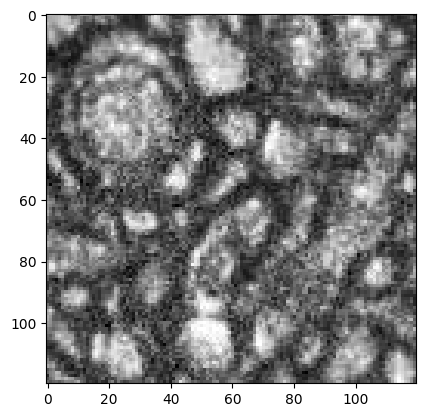

In [28]:
# Examine image
plt.imshow(image[:, :, 30, :], cmap='gray')

In [ ]:
# Get segmentation
seg = CloudVolume(
    'gs://liconn-public/ExPID82_1/segmentation/231030_agg_230921_cmpl', 
    parallel=True, 
    progress=True, 
    mip=[18, 18, 24], 
    fill_missing=True
)

segmentation = seg[1000:1120, 2000:2120, 400:490]
ic.composite_overlay(segmentation[:, :, 30, :], imagery=image[:, :, 30, :], palette='husl')[0]

In [51]:
# Save as h5 for ffn
with h5py.File('data/liconn_tiny.h5', 'w') as f:
    f.create_dataset('raw', data=image, compression='gzip')

## Exporting to webknossos for RoboEM

In [61]:
for i in range(image.shape[2]):
    Image.fromarray(image[:, :, i, 0]).save(f'data/liconn_tiny_tiff/liconn_tiny_{i:02}.tif')

In [66]:
dataset = Dataset.from_images(
    input_path = 'data/liconn_tiny_tiff',
    output_path = 'data/liconn_tiny_wkw',
    voxel_size = (18, 18, 24),
    layer_category = COLOR_CATEGORY,
    compress = True
)

/home/nicolas/Desktop/projects/eon_systems/proofreading/.conda/lib/python3.11/site-packages/r
ich/live.py:221: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/nicolas/Desktop/projects/eon_systems/proofreading/.conda/lib/python3.11/site-packages/webknossos/dataset/_utils/buffered_slice_writer.py:85: UserWarning: [WARNING] Using a buffer size that doesn't align with the datataset's chunk size, will slow down the buffered slice writer.
  warnings.warn(


### Examine flyEM image data to decide on using CLAHE

flyEM is the example dataset used in the ffn repository. The ffn paper suggests normalising images with CLAHE. I wanted to find out which image preprocessing has been done on flyEM that we may have to match for liconn

In [7]:
with h5py.File('data/flyEM/grayscale_maps.h5', 'r') as f:
    flyem = np.array(f['raw'])

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        5.00000e+00, 7.00000e+00, 1.00000e+01, 1.50000e+01, 2.00000e+01,
        1.80000e+01, 2.70000e+01, 2.80000e+01, 4.30000e+01, 6.90000e+01,
        7.00000e+01, 1.10000e+02, 1.50000e+02, 1.84000e+02, 2.32000e+02,
        3.21000e+02, 3.94000e+02, 5.21000e+02, 6.18000e+02, 8.28000e+02,
        1.10000e+03, 1.45300e+03, 1.79400e+03, 2.35800e+03, 2.97400e+03,
        3.86300e+03, 5.06900e+03, 6.30300e+03, 8.09800e+03, 1.02240e+04,
        1.25430e+04, 1.56080e+04, 1.90230e+04, 2.32

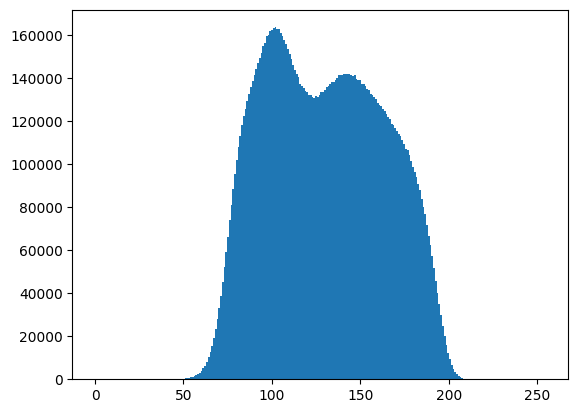

In [17]:
plt.hist(flyem.flatten(), bins=256, range=[0, 255])
plt.show()

as we see, the histogram does not cover the whole range -> no CLAHE done (Clahe may be done automatically in the ffn pipeline, but no guarantees)

#### Extract same size image from liconn (for approximately same resolution, set mip=0)

  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/nicolas/Desktop/projects/eon_systems/proofreading/.conda/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/nicolas/Desktop/projects/eon_systems/proofreading/.conda/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING

[]


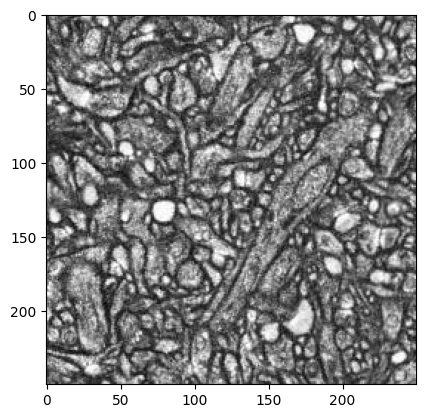

In [9]:
vol = CloudVolume('gs://liconn-public/ExPID82_1/image_230130b', parallel=True, progress=True, mip=2, fill_missing=True)
image = vol[250:500, 750:1000, 100:350, :]
plt.imshow(image[:, :, 0, :], cmap='gray')
print(dxs)

(array([  7501.,   1373.,   1566.,   1848.,   2007.,   2488.,   2773.,
          3122.,   3494.,   3858.,   4254.,   4852.,   5301.,   6028.,
          6773.,   7398.,   8135.,   8849.,   9629.,  10695.,  11761.,
         12280.,  13820.,  14921.,  15880.,  17248.,  18454.,  20055.,
         21094.,  22459.,  24062.,  25470.,  27430.,  28843.,  30454.,
         32361.,  34143.,  35323.,  37360.,  39423.,  41055.,  42980.,
         45186.,  46959.,  48984.,  50521.,  52937.,  55098.,  56804.,
         58687.,  60330.,  62717.,  64438.,  65941.,  68235.,  70228.,
         71982.,  73872.,  75905.,  76974.,  78511.,  80507.,  81971.,
         83149.,  85389.,  86958.,  87819.,  88980.,  90956.,  91628.,
         92981.,  94103.,  95257.,  96536.,  96387.,  97891.,  98587.,
         98652., 100542., 100613., 101331., 102090., 101516., 102666.,
        103236., 103522., 102993., 103765., 103426., 104027., 104167.,
        103886., 103998., 104058., 103817., 104047., 103716., 103534.,
      

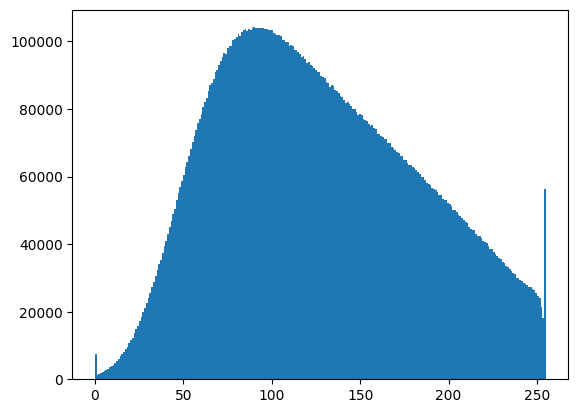

In [ ]:
plt.hist(image.flatten(), bins=256, range=[0, 255])
plt.show()

as we see the histogram is flatter, making CLAHE less useful